In [10]:
import numpy as np
import cv2
import imutils
import matplotlib.pyplot as plt

def show_img(image):
    plt.figure(figsize=(16,16))
    if(len(image.shape) == 2):
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)

In [11]:
train = cv2.imread("../vision/template-2.jpg")
train_gray = cv2.cvtColor(train, cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create()
kpTrain, desTrain = sift.detectAndCompute(train_gray, None)

In [12]:
def test(test_gray):
    kpTest, desTest = sift.detectAndCompute(test_gray, None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(desTrain, desTest,k=2)
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    MIN_MATCH_COUNT = 10
    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kpTrain[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kpTest[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()

        h,w = train_gray.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

        dst = cv2.perspectiveTransform(pts,M)

        ret = np.int32(dst)[:,0,:]

        # at least 0
        ret[ret < 0] = 0
        th,tw = test_gray.shape
        
        # not to exceed width
        mask = np.zeros_like(ret)
        mask[:,0] = 1
        ret[(ret > tw) & (mask == 1)] = tw

        # not to exceed height
        mask = np.zeros_like(ret)
        mask[:,1] = 1
        ret[(ret > th) & (mask == 1)] = th

        return ret

    else:
        print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
        matchesMask = None
        return None

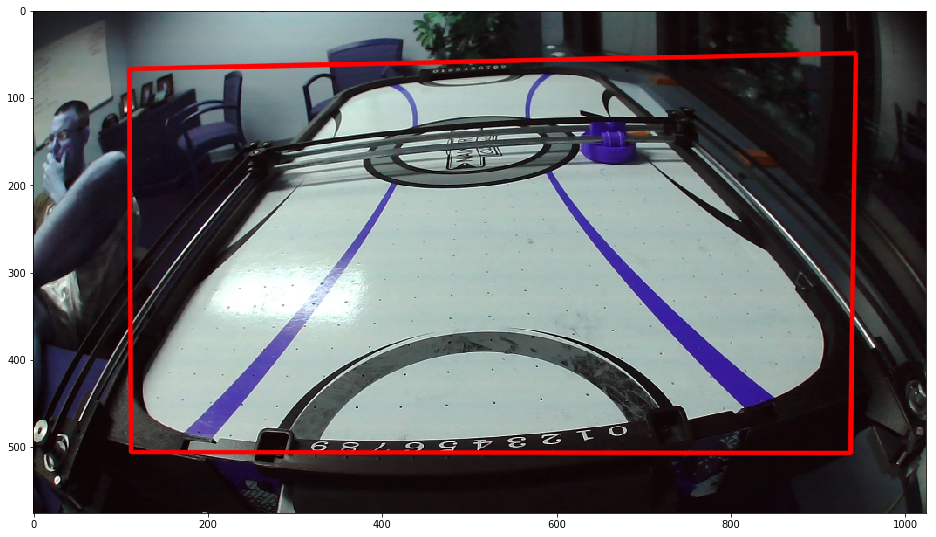

In [13]:
test_img = cv2.imread("../vision/night.jpg")
test_img_gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
rect = test(test_img_gray)
test_lined = cv2.polylines(test_img.copy(),[rect],True,255,3, cv2.LINE_AA)
show_img(test_lined)

In [132]:
rects = {
    "top": {
        "left": {
            "x": np.array([], dtype=np.int32),
            "y": np.array([], dtype=np.int32)
        },
        "right": {
            "x": np.array([], dtype=np.int32),
            "y": np.array([], dtype=np.int32)
        }
    },
    "bottom": {
        "left": {
            "x": np.array([], dtype=np.int32),
            "y": np.array([], dtype=np.int32)
        },
        "right": {
            "x": np.array([], dtype=np.int32),
            "y": np.array([], dtype=np.int32)
        }
    }
}

In [150]:
rects["top"]["left"]["x"] = np.append(rects["top"]["left"]["x"], rect[0][0])
rects["top"]["left"]["y"] = np.append(rects["top"]["left"]["y"], rect[0][1])
rects["bottom"]["left"]["x"] = np.append(rects["bottom"]["left"]["x"], rect[1][0])
rects["bottom"]["left"]["y"] = np.append(rects["bottom"]["left"]["y"], rect[1][1])
rects["bottom"]["right"]["x"] = np.append(rects["bottom"]["right"]["x"], rect[2][0])
rects["bottom"]["right"]["y"] = np.append(rects["bottom"]["right"]["y"], rect[2][1])
rects["top"]["right"]["x"] = np.append(rects["top"]["right"]["x"], rect[3][0])
rects["top"]["right"]["y"] = np.append(rects["top"]["right"]["y"], rect[3][1])

In [164]:
rects["top"]["left"]["x"] = rects["top"]["left"]["x"][-2:]
rects["top"]["left"]["x"]

array([110,   3], dtype=int32)

In [143]:
average = np.array([
        [np.average(rects["top"]["left"]["x"]), np.average(rects["top"]["left"]["y"])],
        [np.average(rects["bottom"]["left"]["x"]), np.average(rects["bottom"]["left"]["y"])],
        [np.average(rects["bottom"]["right"]["x"]), np.average(rects["bottom"]["right"]["y"])],
        [np.average(rects["top"]["right"]["x"]), np.average(rects["top"]["right"]["y"])]
], dtype=np.int32)
average

array([[110,  67],
       [112, 506],
       [937, 507],
       [943,  49]], dtype=int32)

In [71]:
np.append(top_lefts, rect[0][0])
rect, rect[0][0], top_lefts

(array([[110,  67],
        [112, 506],
        [937, 507],
        [943,  49]], dtype=int32), 110, array([2, 2, 2]))

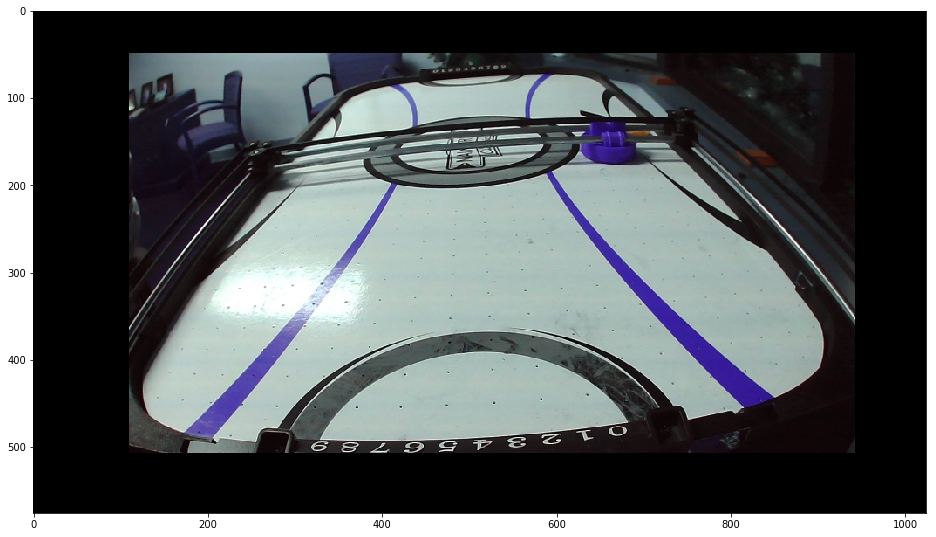

In [7]:
just_rect = np.zeros_like(test_img)
just_rect[min(rect[:,1]):max(rect[:,1]), min(rect[:,0]):max(rect[:,0])] = test_img[min(rect[:,1]):max(rect[:,1]), min(rect[:,0]):max(rect[:,0])]
show_img(just_rect)

In [8]:
import imutils
from imutils.video import WebcamVideoStream
vs = WebcamVideoStream(src=0)
vs = vs.start()
img = imutils.resize(vs.read(), width=1024)
vs.stop()
show_img(img)

AttributeError: 'NoneType' object has no attribute 'shape'

[[   0   86]
 [   0  676]
 [1024  678]
 [1024   73]]


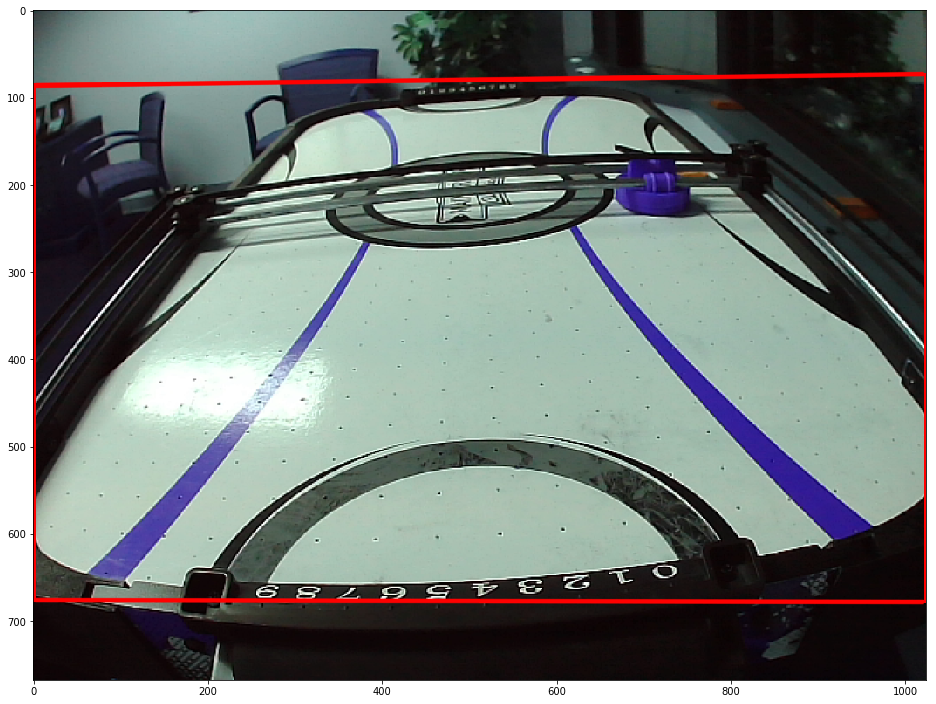

In [85]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
rect = test(img_gray)
print(rect)
result = cv2.polylines(img.copy(),[rect],True,255,3, cv2.LINE_AA)
show_img(result)

In [86]:
img_gray.shape

(768, 1024)

In [87]:
rect2 = rect
w = 600
rect2[rect2 < 0] = 0
mask = np.zeros_like(rect)
mask[:,1] = 1
rect2[(rect2 > w) & (mask == 1)] = w
rect

array([[   0,   86],
       [   0,  600],
       [1024,  600],
       [1024,   73]], dtype=int32)

In [9]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv2.drawMatches(train,kpTrain,test_lined,kpTest,good,None,**draw_params)

show_img(img3)

NameError: name 'matchesMask' is not defined

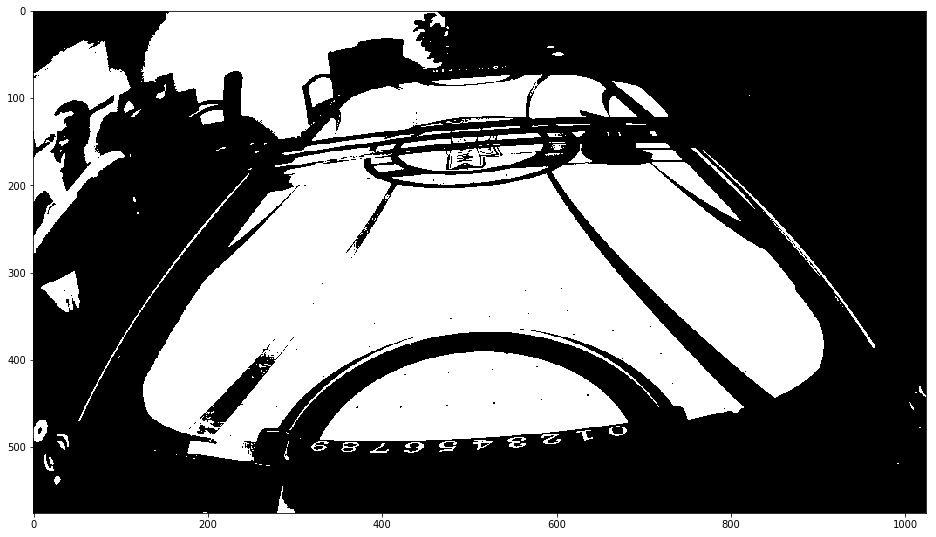

In [321]:
test = cv2.imread("./images/night.jpg")
test_gray = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(test_gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
show_img(thresh)

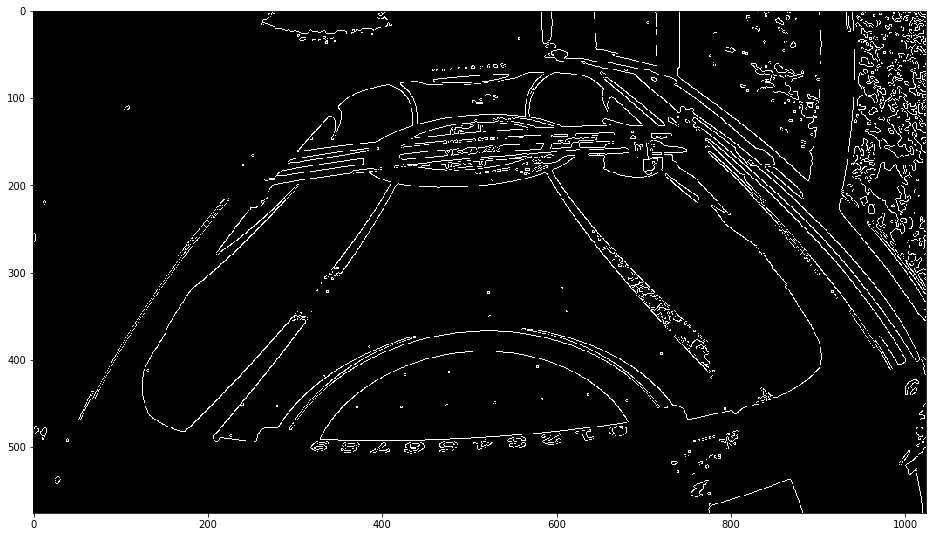

In [296]:
edges = cv2.Canny(thresh, 1, 1)
show_img(edges)

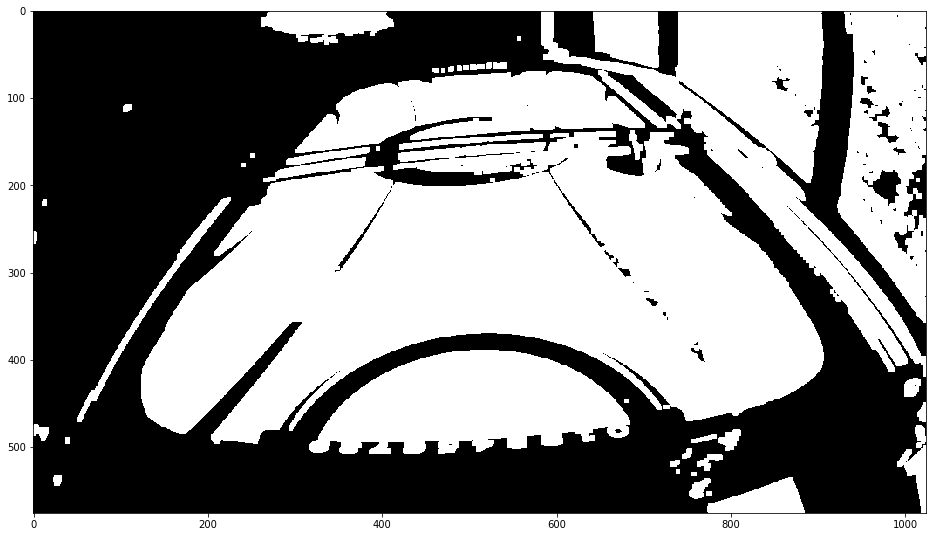

In [295]:
kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(thresh, kernel, iterations = 1)
show_img(dilation)

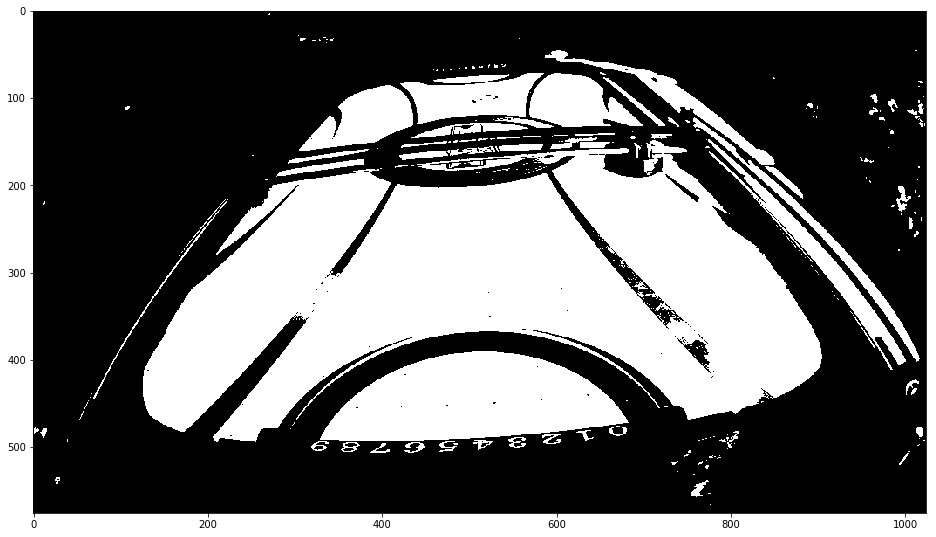

In [314]:
from skimage import segmentation, filters, img_as_ubyte

mask = test_gray > filters.threshold_otsu(test_gray)
clean_border = segmentation.clear_border(mask)
show_img(clean_border)

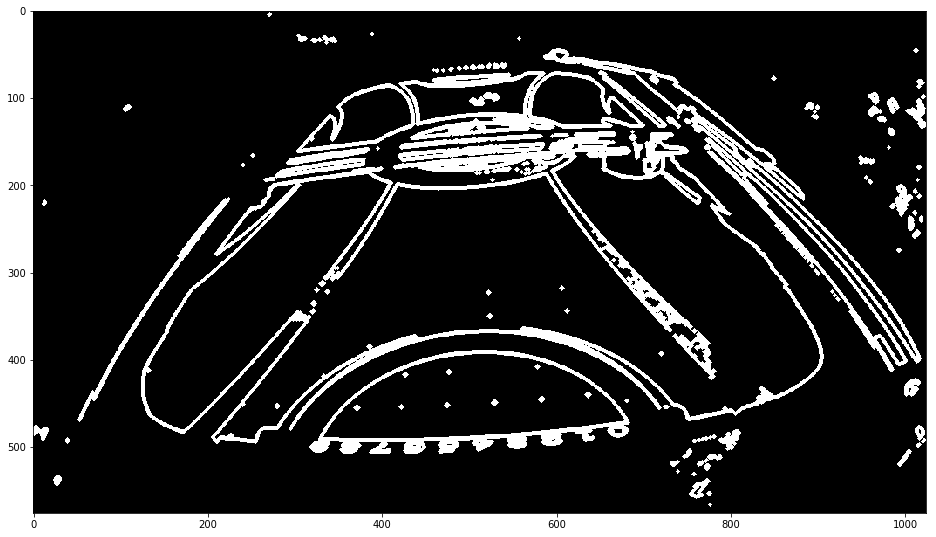

In [315]:
cv_image = img_as_ubyte(clean_border)
no_lava = np.zeros_like(cv_image)
im2, contours, hierarchy = cv2.findContours(cv_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
c = max(contours, key = cv2.contourArea)
cv2.drawContours(no_lava, contours, -1, (255,255,255), 3)
show_img(no_lava)

In [313]:
def remove_noise(image):
    wk_img=image.copy()
    
    # Baseline params
    kernel1=5
    kernel2=60
    while True:    
        kernel = np.ones((kernel1,kernel2))
        opened=cv2.morphologyEx(wk_img,cv2.MORPH_OPEN, kernel)    
        zero_count_l=np.count_nonzero(opened[:,:120])
        zero_count_r=np.count_nonzero(opened[:,1780:])
        if zero_count_l > 0 or zero_count_r > 0:
            kernel2+=1
        else:
            break

    closed=cv2.morphologyEx(opened, cv2.MORPH_CLOSE, np.ones((10,10)))
    return closed.copy()

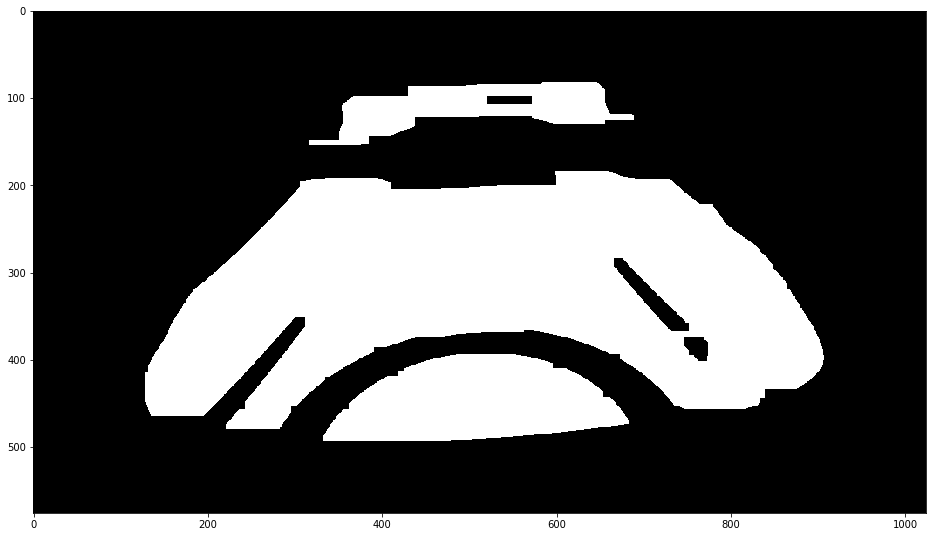

In [312]:
clean_img = remove_noise(cv_image)
show_img(clean_img)